# 7 - Ising Model: Uniform Sampling

##### Imports:

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.integrate as integrate

I will create a dataframe later on: so I'll import pandas.

In [88]:
import pandas as pd

##### Configure matplotlib settings

In [42]:
plt.style.use('ggplot')
plt.rcParams.update(
    {"text.usetex": True,
     'font.serif': 'Modern Roman',
     "figure.figsize": (10, 4),
    "axes.titlesize" : 26,
    "axes.labelsize" : 28,
    "lines.linewidth": 3,
    "lines.markersize" : 10,
    "xtick.labelsize" : 24,
    "ytick.labelsize" : 24})

##### Functions:

In [2]:
def random_spins(N):
    '''Generate a N x N random lattice of spins, represented as a vector of length N^2.'''
    spins = [-1, 1]
    
    lattice = []
    for i in range(N**2):
        lattice.append(random.choice(spins))
    
    return lattice

In [3]:
def compute_energy(lattice):
    '''Given a lattice, computes the energy according to Hamiltonian for the Ising model.'''
    E = 0
    N = int(np.sqrt(len(lattice))) # obtain N, given the lattice
    
    for i in range(len(lattice)):
        s = lattice[i]
        E += -s*lattice[(i + N + N**2)%N**2]
        E += -s*lattice[(i -  N + N**2)%N**2]
        
        E += -s*lattice[(i + 1 + N**2)%N**2]
        E += -s*lattice[(i -  1 + N**2)%N**2]
    return E/2

In [108]:
def ising_uniform_sampling(N):
    '''Returns a lattice of uniformly generated spins and computes the energies per bond of a lattice, using uniform sampling.'''
    lattice = random_spins(N)
    e = compute_energy(lattice)/(2*N**2) 
    lattice.append(e)
    return lattice

In [117]:
def hit_and_miss(N, T):
    '''Applies the hit and miss algorithm a single time. If a hit, returns the generated lattice, and its energy. Note:  k_b = 1'''
    beta = 1/T
    E0 = -2*N**2
    
    lattice = random_spins(N)
    E = compute_energy(lattice)
    r = random.uniform(0, 1)
    
    if r <= np.exp(-beta*(E - E0)):
        lattice.append(E/(2*N**2)) # work with e instead of E
        return lattice # hit
   
    else:
        return 'miss'

In [118]:
def hit_and_miss_algorithm(N, T, nreps):
    '''Runs the hit and miss nreps times. Returns the hits = lattices and their energy, and the fraction of hits (useful for exercise 7.2)'''
    lattice_list = []
    
    for i in range(nreps):
        lattice = hit_and_miss(N, T) # result from hit_and_miss is lattice configuration + E
    
        if lattice != 'miss':
            lattice_list.append(lattice)
    
    return (lattice_list, len(lattice_list)/nreps)

In [209]:
def get_weights(energies, T):
    weights = []
    for E in energies:
        weights.append(np.exp(-E/T))
        
    return weights

We check that the function calculates energies correctly: check this for the ground state: should be $E_0 = -2N^2$.

In [5]:
# Check that the 'compute_energy' function gives the correct result for the ground state.

ground_state = [1, 1, 1, 1, 1, 1, 1, 1, 1] # ground state for N = 3
compute_energy(ground_state)

-18.0

 ## 7.0 : e = 1? TEST: DELETE THIS

In [119]:
# N = 3:
lattice = [1, -1, 1, -1, 1, -1, 1, -1, 1]

In [120]:
compute_energy(lattice)

10.0

## 7.1 - Histogram of energies per bond

In [149]:
N = 16; nreps = 10**5

The following command block takes a bit of time to run, depending on how large $N$ and $nreps$ are.

In [150]:
uniform_e_list = []

for i in range(nreps):
    uniform_e_list.append(ising_uniform_sampling(N)[-1])

Plot the histogram:

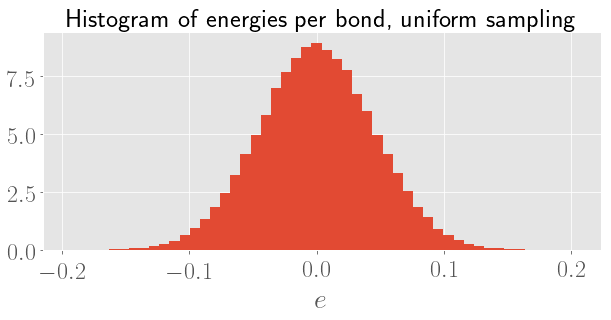

In [202]:
u_counts, u_bins, bars = plt.hist(uniform_e_list, density = True, bins = 50) # save the counts and bins for later
plt.title('Histogram of energies per bond, uniform sampling')
plt.xlabel(r'$e$')
plt.savefig('ex7_histogram_e_uniform.pdf', bbox_inches = 'tight')
plt.show()

For N = 16: Gaussian between -0.2, 0.2?

## 7.2 - Hit and miss method

In [85]:
T1 = 10**5; T2 = 10**3; T3 = 10**2; T4 = 10
temperatures = [T1, T2, T3, T4]

Determine the fractions of saved hits. Number of runs can be changed below.

In [121]:
nreps = 10**3

In [122]:
fracs_N = {4 : [], 8 : [], 12 : [], 16 : []}
for key in fracs_N:
    
    fracs = []
    for T in temperatures:
        fracs_N[key].append(100*hit_and_miss_algorithm(key, T, nreps)[1]) # save as a percentage

In [123]:
df = pd.DataFrame.from_dict(fracs_N, orient = 'index', columns = ['T1', 'T2', 'T3', 'T4'])

In [124]:
df

,T1,T2,T3,T4
4,99.8,95.8,72.6,5.3
8,99.6,87.0,28.7,0.0
12,99.7,74.9,6.4,0.0
16,99.3,57.7,0.5,0.0


Export latex code to recreate this tabular

In [95]:
#print(df.to_latex(index = True))  

Recall that the critical temperatur for the Ising model is:

In [114]:
TC = 2/np.log(1 + np.sqrt(2))
print(TC)

2.269185314213022


## 7.3 Reweighting technique

We will first compare a histogram

Initialise: 

In [237]:
T = T2; N = 12; nreps = 10**5

Get a histogram for this temperature, using the hit-and-miss method.

The following command block takes a bit of time.

In [238]:
e_list = []
states, frac = hit_and_miss_algorithm(N, T, nreps)

for state in states:
    e_list.append(state[-1])

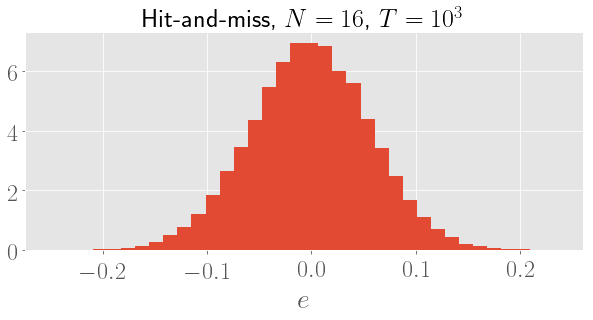

In [260]:
plt.hist(e_list, density = True, bins = 36)
plt.title(r'Hit-and-miss, $N = 16$, $T = 10^3$')
plt.xlabel(r'$e$')
plt.savefig('ex7_histogram_hit_and_missT2.pdf', bbox_inches = 'tight')
plt.show()

Get the histogram via reweighting technique: first get the uniform histogram.

Get the uniform histogram: (the following command block takes a bit of time)

In [240]:
uniform_e_list = []

for i in range(nreps):
    uniform_e_list.append(ising_uniform_sampling(N)[-1])

In [241]:
weights = get_weights(uniform_e_list, T)

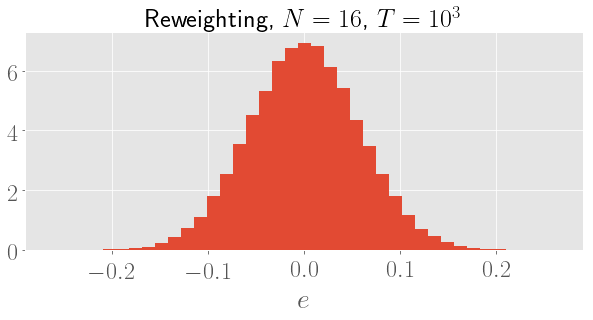

In [281]:
plt.hist(uniform_e_list, density = True, bins = 39, weights = weights)
plt.title(r'Reweighting, $N = 16$, $T = 10^3$')
plt.xlabel(r'$e$')
plt.savefig('ex7_histogram_reweighting_demonstration.pdf', bbox_inches = 'tight')
plt.show()

This histogram agrees with what we obtain using the hit-and-miss method.

#### Generate histograms for various temperatures

In [262]:
# Save the temperatures in a list:
temperatures = [10**5, 10**3, 10, 2]

In [263]:
weight_list = []
for t in temperatures:
    weight_list.append(get_weights(uniform_e_list, t))

In [285]:
min(weight_list[-1])

0.8763896820426141

Make sure that the command block above, generating $\texttt{uniform_e_list}$ has been runned.

Create four histograms using subplots.

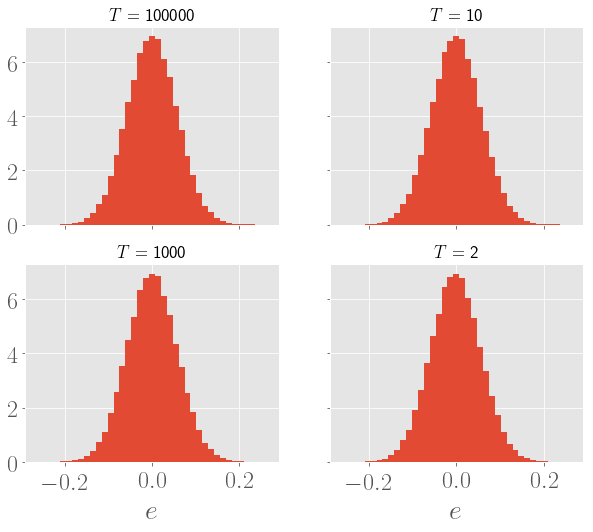

In [280]:
fig, axs = plt.subplots(2, 2, figsize = (10, 8))
bins_list = [39, 39, 39, 39] # play around with number of bins to get optimal results
for i in range(len(temperatures)):
    
    axs[i % 2, i // 2].hist(uniform_e_list, density = True, bins = bins_list[i], weights = weight_list[i])
    axs[i % 2, i // 2].set_title(r'$T = $ %d' % temperatures[i], size = 18)

for ax in axs.flat:
    ax.set(xlabel=r'$e$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.savefig('ex7_four_histograms_reweighting.pdf', bbox_inches = 'tight')
plt.show()